I'll start by listing some assumptions I made regarding the data. The following link is the original source.
https://brunel.figshare.com/articles/dataset/Supply_Chain_Logistics_Problem_Dataset/7558679

## Order flow

- When an order comes in, a decision has to be made in regards to which plant it should be processed or stored at, taking into account customer preference or given plant-product combination
- From the plant, the order is then transported to the respective ports which can be chosen from various plant-port combinations
- From the port(termed as origin port), the carrier transports the goods to the destination port, which can again be chosen from the port-carrier combination

## Warehouse Constraints

- Each warehouse has a limited capacity to store items and the cost per unit to store items has been given.

## Freight Constraints

- Each carrier has a defined minimum and maximum weight quantity that it can load upon itself, a service level, origin and destination port as well as minimum cost to use that carrier.
- Each carrier has defined its rate on total weight basis i.e., total weight of any particular order.

## CRF orders

- CRF orders are dropped from the data set. The original source for this set indicated that CRF orders are "customer arranged shipping".


In [15]:
#importing libraries
import os
import pandas as pd
import numpy as np
file = pd.ExcelFile('Supply chain logisitcs problem.xlsx')
pd.options.mode.chained_assignment = None

plant_ports = file.parse("PlantPorts")
order_list = file.parse("OrderList")
products_plants = file.parse("ProductsPerPlant")
vmi_plants = file.parse("VmiCustomers")
freight_rates = file.parse("FreightRates")
wh_cost = file.parse("WhCosts")

#clean column names
order_list.columns = [i.replace(" ", "_") for i in order_list.columns]
products_plants.columns = [i.replace(" ", "_") for i in products_plants.columns]
plant_ports.columns = [i.replace(" ", "_") for i in plant_ports.columns]
vmi_plants.columns = [i.replace(" ", "_") for i in vmi_plants.columns]
freight_rates.columns = [i.replace(" ", "_") for i in freight_rates.columns]

wh_cost = pd.DataFrame(wh_cost)
wh_cost.columns = [i.replace("/", "") for i in wh_cost.columns]

wh_cost.set_index("WH", inplace=True)

#clean order list; remove orders with CRF - these orders are customer-arranged shipping
order_list.drop(order_list.index[order_list['Service_Level']=='CRF'], inplace=True)
order_list['Order_ID'] = order_list['Order_ID'].astype(int)
order_list.set_index('Order_ID', inplace=True)

# these columns are dropped because they represents historical decisions
ol = order_list.drop(columns=["Order_Date", "Origin_Port", "Carrier", "Plant_Code", "TPT", 
                                 "Ship_ahead_day_count", "Ship_Late_Day_count"])

### For original OrderList

In [16]:
ol1 = order_list.drop(columns=["Order_Date", "TPT", "Ship_ahead_day_count", "Ship_Late_Day_count"])
ol1

,Origin_Port,Carrier,Service_Level,Customer,Product_ID,Plant_Code,Destination_Port,Unit_quantity,Weight
Order_ID,,,,,,,,,
1447385217,PORT09,V444_0,DTP,V55555_4,1692724,PLANT16,PORT09,332,1.023143
1447337778,PORT09,V444_0,DTP,V55555_4,1692724,PLANT16,PORT09,358,0.613886
1447406947,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,409,37.041956
1447154164,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,438,42.830667
1447163388,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,824,133.224269
...,...,...,...,...,...,...,...,...,...
1447305022,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
1447318796,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
1447322251,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,245,0.294265


In [17]:
#for a given input order_id-plant-port combo, create a table of possible routes and their associated costs (minimum or weight*rate)
# Select the lowest one. If none available, return None

def carrier_result(Order_ID):
    select_origin_port = ol1.loc[Order_ID]['Origin_Port']
    select_dest_port = ol1.loc[Order_ID]['Destination_Port']
    service_level = ol1.loc[Order_ID]['Service_Level']
    weight_container = ol1.loc[Order_ID]['Weight']
    
    
    try:
        suit_carr = freight_rates[(freight_rates.orig_port_cd==select_origin_port)&(freight_rates.dest_port_cd==select_dest_port)&(freight_rates.svc_cd==service_level)&(weight_container>freight_rates.minm_wgh_qty)&(weight_container<freight_rates.max_wgh_qty)]
    
        suit_carr['rate_cost'] = suit_carr.rate*weight_container
        suit_carr["select_cost"] = suit_carr[["rate_cost", "minimum_cost"]].max(axis=1)
    
        apt_carr = suit_carr.loc[suit_carr['select_cost'].idxmin()]

        result = round(apt_carr['select_cost'],4)
        return result
    except:
        return None 

carrier_result(1447337778)

31.2784

In [18]:
ol1["freight_cost"] = np.array(list(map(carrier_result, ol.index)), dtype=object)
ol1

,Origin_Port,Carrier,Service_Level,Customer,Product_ID,Plant_Code,Destination_Port,Unit_quantity,Weight,freight_cost
Order_ID,,,,,,,,,,
1447385217,PORT09,V444_0,DTP,V55555_4,1692724,PLANT16,PORT09,332,1.023143,31.2784
1447337778,PORT09,V444_0,DTP,V55555_4,1692724,PLANT16,PORT09,358,0.613886,31.2784
1447406947,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,409,37.041956,454.816
1447154164,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,438,42.830667,525.8921
1447163388,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,824,133.224269,1635.7809
...,...,...,...,...,...,...,...,...,...,...
1447305022,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118,1.4416
1447318796,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118,1.4416
1447322251,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,245,0.294265,1.202


In [19]:
def find_plant_cost(order_select):
    plant_given = ol1.loc[order_select]['Plant_Code']
    rate_check = wh_cost.loc[plant_given]['Costunit']
    whouse_cost = ol1.loc[order_select]['Unit_quantity']
    whouse_cost = whouse_cost*rate_check
    warehousing_costs = [rate_check, whouse_cost]
    return warehousing_costs

find_plant_cost(1447328130)

[0.5175018916254618, 164.04809964527138]

In [20]:
ol1[["wh_rate",'wh_cost']] = np.array(list(map(find_plant_cost, ol1.index)), dtype=object)
ol1

,Origin_Port,Carrier,Service_Level,Customer,Product_ID,Plant_Code,Destination_Port,Unit_quantity,Weight,freight_cost,wh_rate,wh_cost
Order_ID,,,,,,,,,,,,
1447385217,PORT09,V444_0,DTP,V55555_4,1692724,PLANT16,PORT09,332,1.023143,31.2784,1.919808,637.376093
1447337778,PORT09,V444_0,DTP,V55555_4,1692724,PLANT16,PORT09,358,0.613886,31.2784,1.919808,687.291088
1447406947,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,409,37.041956,454.816,1.919808,785.201271
1447154164,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,438,42.830667,525.8921,1.919808,840.875688
1447163388,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,824,133.224269,1635.7809,1.919808,1581.921386
...,...,...,...,...,...,...,...,...,...,...,...,...
1447305022,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118,1.4416,0.517502,175.433141
1447318796,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118,1.4416,0.517502,175.433141
1447322251,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,245,0.294265,1.202,0.517502,126.787963


In [21]:
ol1['total_cost'] = ol1['freight_cost'] + ol1['wh_cost']
ol1

,Origin_Port,Carrier,Service_Level,Customer,Product_ID,Plant_Code,Destination_Port,Unit_quantity,Weight,freight_cost,wh_rate,wh_cost,total_cost
Order_ID,,,,,,,,,,,,,
1447385217,PORT09,V444_0,DTP,V55555_4,1692724,PLANT16,PORT09,332,1.023143,31.2784,1.919808,637.376093,668.654493
1447337778,PORT09,V444_0,DTP,V55555_4,1692724,PLANT16,PORT09,358,0.613886,31.2784,1.919808,687.291088,718.569488
1447406947,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,409,37.041956,454.816,1.919808,785.201271,1240.017271
1447154164,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,438,42.830667,525.8921,1.919808,840.875688,1366.767788
1447163388,PORT09,V444_0,DTP,V555555_6,1692722,PLANT16,PORT09,824,133.224269,1635.7809,1.919808,1581.921386,3217.702286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447305022,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118,1.4416,0.517502,175.433141,176.874741
1447318796,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118,1.4416,0.517502,175.433141,176.874741
1447322251,PORT04,V444_1,DTD,V55555555555555_8,1683388,PLANT03,PORT09,245,0.294265,1.202,0.517502,126.787963,127.989963


In [22]:
eligible_orders = ol1[~ol1['total_cost'].isnull()]

In [68]:
total_cost_summed_original = eligible_orders['total_cost'].sum()
print("$", round(total_cost_summed_original,2))

$ 13408382.6


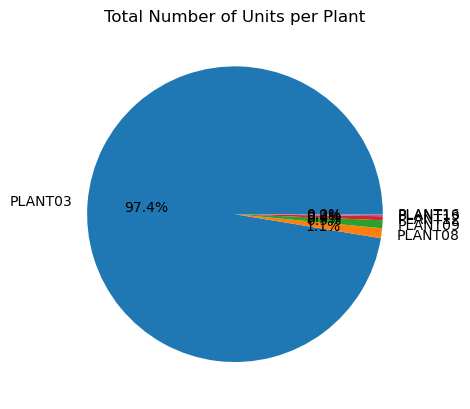

In [73]:
import matplotlib.pyplot as plt

# Group by plant and calculate the total units
units_per_plant = eligible_orders.groupby('Plant_Code')['Unit_quantity'].sum()

# Create a pie chart
plt.pie(units_per_plant, labels=units_per_plant.index, autopct='%1.1f%%')
plt.title('Total Number of Units per Plant')

plt.show()


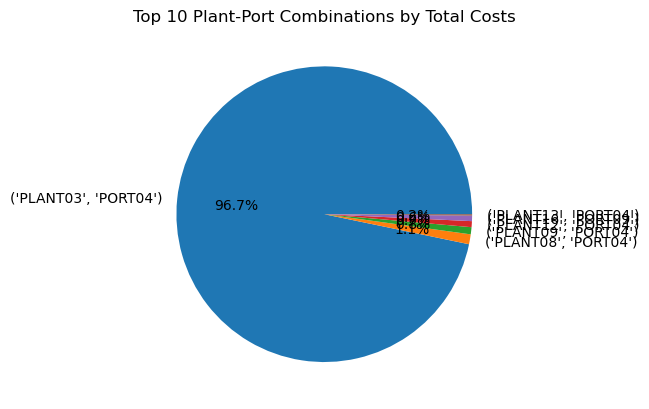

In [74]:
import matplotlib.pyplot as plt

# Group by plant and port combination and calculate the total costs
total_costs_per_combo = eligible_orders.groupby(['Plant_Code', 'Origin_Port'])['total_cost'].sum()

# Sort the combinations based on total costs in descending order
total_costs_per_combo = total_costs_per_combo.sort_values(ascending=False)

# Select the top N combinations
N = 10  # Specify the number of top combinations to include
top_combinations = total_costs_per_combo.head(N)

# Create a pie chart to visualize the top combinations
plt.pie(top_combinations, labels=top_combinations.index, autopct='%1.1f%%')
plt.title('Top {} Plant-Port Combinations by Total Costs'.format(N))

plt.show()


### Customer restriction: certain products only fulfilled at certain plant due to vendor managed inventory (vmi)

In [24]:
def cust_vmi_restr(order_select):
    order_data = ol.loc[order_select]
    order_cust_id = order_data["Customer"]
    vmi_check = vmi_plants.loc[vmi_plants["Customers"] == order_cust_id]
    return vmi_check["Plant_Code"].tolist()

# example vmi restriced
cust_vmi_restr(1447365956)

['PLANT02', 'PLANT10']

In [25]:
# example vmi unrestricted
cust_vmi_restr(1447184437)

[]

### In case of no customer restriction, Product ID will direct us to available plants 

In [26]:
def prod_plant_restr(order_select):
    order_data = ol.loc[order_select]
    order_prod_id = order_data["Product_ID"]
    prod_check = products_plants.loc[products_plants["Product_ID"] == order_prod_id]
    return prod_check["Plant_Code"].tolist()

prod_plant_restr(1447221843)

['PLANT02', 'PLANT10', 'PLANT11', 'PLANT03']

### List of available plants for any Order 

In [27]:
def avail_plants(order_select):
    vmi_plant_list = cust_vmi_restr(order_select)
    if vmi_plant_list == []:
        prod_plant_list = prod_plant_restr(order_select)
        return prod_plant_list
    else:
        return vmi_plant_list


avail_plants(1447221844)

['PLANT02', 'PLANT10', 'PLANT11', 'PLANT03']

### return available plant(s) to a new column

In [28]:
ol["avail_plant"] = np.array(list(map(avail_plants, ol.index)), dtype=object)

### Overview of various plant options and their frequencies for orders

In [29]:
result = pd.DataFrame(ol["avail_plant"].value_counts())
result = result.reset_index()
result = result.rename(columns={'index':'plant_options_for_order','avail_plant':'count'})
result

,plant_options_for_order,count
0,[PLANT03],4590
1,[PLANT02],1677
2,"[PLANT02, PLANT10, PLANT11, PLANT03]",911
3,"[PLANT03, PLANT04]",245
4,"[PLANT02, PLANT10]",226
5,"[PLANT05, PLANT03]",151
6,[PLANT12],109
7,"[PLANT02, PLANT03]",89
8,"[PLANT09, PLANT03]",53
9,"[PLANT10, PLANT07, PLANT03, PLANT08]",47


### Explode avail_plant to create one row for each possible order-plant combination

In [30]:
ol = ol.explode("avail_plant")
ol["id_plant_combo"] = ol.index.astype(str) + ol['avail_plant']
ol

,Service_Level,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,avail_plant,id_plant_combo
Order_ID,,,,,,,,
1447385217,DTP,V55555_4,1692724,PORT09,332,1.023143,PLANT16,1447385217PLANT16
1447337778,DTP,V55555_4,1692724,PORT09,358,0.613886,PLANT16,1447337778PLANT16
1447406947,DTP,V555555_6,1692722,PORT09,409,37.041956,PLANT16,1447406947PLANT16
1447154164,DTP,V555555_6,1692722,PORT09,438,42.830667,PLANT16,1447154164PLANT16
1447163388,DTP,V555555_6,1692722,PORT09,824,133.224269,PLANT16,1447163388PLANT16
...,...,...,...,...,...,...,...,...
1447305022,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447305022PLANT02
1447318796,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447318796PLANT02
1447322251,DTD,V55555555555555_8,1683388,PORT09,245,0.294265,PLANT02,1447322251PLANT02


In [31]:
#change index to Order_ID-Plant combo, this is preperation for the next steps

ol["Order_ID"] = ol.index
ol.set_index('id_plant_combo', inplace=True)
ol

,Service_Level,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,avail_plant,Order_ID
id_plant_combo,,,,,,,,
1447385217PLANT16,DTP,V55555_4,1692724,PORT09,332,1.023143,PLANT16,1447385217
1447337778PLANT16,DTP,V55555_4,1692724,PORT09,358,0.613886,PLANT16,1447337778
1447406947PLANT16,DTP,V555555_6,1692722,PORT09,409,37.041956,PLANT16,1447406947
1447154164PLANT16,DTP,V555555_6,1692722,PORT09,438,42.830667,PLANT16,1447154164
1447163388PLANT16,DTP,V555555_6,1692722,PORT09,824,133.224269,PLANT16,1447163388
...,...,...,...,...,...,...,...,...
1447305022PLANT02,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447305022
1447318796PLANT02,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447318796
1447322251PLANT02,DTD,V55555555555555_8,1683388,PORT09,245,0.294265,PLANT02,1447322251


## Finding warehousing cost for a given order;
#### Identify the order quantity and multiply it by the warehousing rate in wh_cost

In [32]:
def find_plant_cost(order_select):
    order_avail_plant = ol.loc[order_select]['avail_plant']
    rate_check = wh_cost.loc[order_avail_plant]['Costunit']
    whouse_cost = ol.loc[order_select]['Unit_quantity']
    whouse_cost = whouse_cost*rate_check
    warehousing_costs = [rate_check, whouse_cost]
    return warehousing_costs

print(find_plant_cost('1447385217PLANT16'))

[1.9198075078524335, 637.3760926070079]


### append warehousing rate and total cost to each possible order-plant combination

In [33]:
ol[["wh_rate",'wh_cost']] = np.array(list(map(find_plant_cost, ol.index)), dtype=object)
ol

,Service_Level,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,avail_plant,Order_ID,wh_rate,wh_cost
id_plant_combo,,,,,,,,,,
1447385217PLANT16,DTP,V55555_4,1692724,PORT09,332,1.023143,PLANT16,1447385217,1.919808,637.376093
1447337778PLANT16,DTP,V55555_4,1692724,PORT09,358,0.613886,PLANT16,1447337778,1.919808,687.291088
1447406947PLANT16,DTP,V555555_6,1692722,PORT09,409,37.041956,PLANT16,1447406947,1.919808,785.201271
1447154164PLANT16,DTP,V555555_6,1692722,PORT09,438,42.830667,PLANT16,1447154164,1.919808,840.875688
1447163388PLANT16,DTP,V555555_6,1692722,PORT09,824,133.224269,PLANT16,1447163388,1.919808,1581.921386
...,...,...,...,...,...,...,...,...,...,...
1447305022PLANT02,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447305022,0.477504,161.873693
1447318796PLANT02,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447318796,0.477504,161.873693
1447322251PLANT02,DTD,V55555555555555_8,1683388,PORT09,245,0.294265,PLANT02,1447322251,0.477504,116.988362


### function to define available ship ports for each order-plant combination

In [34]:
def avail_port_for_plant(order_select):
    order_avail_plant = ol.loc[order_select]['avail_plant']
    port_check = plant_ports.loc[plant_ports['Plant_Code'] == order_avail_plant]
    return port_check["Port"].tolist()

avail_port_for_plant('1447385217PLANT16')

['PORT09']

### append port options to each possible order-plant combination


In [35]:
ol["avail_port"] = np.array(list(map(avail_port_for_plant, ol.index)), dtype=object)
ol

,Service_Level,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,avail_plant,Order_ID,wh_rate,wh_cost,avail_port
id_plant_combo,,,,,,,,,,,
1447385217PLANT16,DTP,V55555_4,1692724,PORT09,332,1.023143,PLANT16,1447385217,1.919808,637.376093,[PORT09]
1447337778PLANT16,DTP,V55555_4,1692724,PORT09,358,0.613886,PLANT16,1447337778,1.919808,687.291088,[PORT09]
1447406947PLANT16,DTP,V555555_6,1692722,PORT09,409,37.041956,PLANT16,1447406947,1.919808,785.201271,[PORT09]
1447154164PLANT16,DTP,V555555_6,1692722,PORT09,438,42.830667,PLANT16,1447154164,1.919808,840.875688,[PORT09]
1447163388PLANT16,DTP,V555555_6,1692722,PORT09,824,133.224269,PLANT16,1447163388,1.919808,1581.921386,[PORT09]
...,...,...,...,...,...,...,...,...,...,...,...
1447305022PLANT02,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447305022,0.477504,161.873693,[PORT03]
1447318796PLANT02,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447318796,0.477504,161.873693,[PORT03]
1447322251PLANT02,DTD,V55555555555555_8,1683388,PORT09,245,0.294265,PLANT02,1447322251,0.477504,116.988362,[PORT03]


### Explode avail_port to create one row for each possible order-plant-port combination

In [36]:
ol = ol.explode("avail_port")
ol["id_plant_port_combo"] = ol.index.astype(str) + ol['avail_port']
ol

,Service_Level,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,avail_plant,Order_ID,wh_rate,wh_cost,avail_port,id_plant_port_combo
id_plant_combo,,,,,,,,,,,,
1447385217PLANT16,DTP,V55555_4,1692724,PORT09,332,1.023143,PLANT16,1447385217,1.919808,637.376093,PORT09,1447385217PLANT16PORT09
1447337778PLANT16,DTP,V55555_4,1692724,PORT09,358,0.613886,PLANT16,1447337778,1.919808,687.291088,PORT09,1447337778PLANT16PORT09
1447406947PLANT16,DTP,V555555_6,1692722,PORT09,409,37.041956,PLANT16,1447406947,1.919808,785.201271,PORT09,1447406947PLANT16PORT09
1447154164PLANT16,DTP,V555555_6,1692722,PORT09,438,42.830667,PLANT16,1447154164,1.919808,840.875688,PORT09,1447154164PLANT16PORT09
1447163388PLANT16,DTP,V555555_6,1692722,PORT09,824,133.224269,PLANT16,1447163388,1.919808,1581.921386,PORT09,1447163388PLANT16PORT09
...,...,...,...,...,...,...,...,...,...,...,...,...
1447305022PLANT02,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447305022,0.477504,161.873693,PORT03,1447305022PLANT02PORT03
1447318796PLANT02,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447318796,0.477504,161.873693,PORT03,1447318796PLANT02PORT03
1447322251PLANT02,DTD,V55555555555555_8,1683388,PORT09,245,0.294265,PLANT02,1447322251,0.477504,116.988362,PORT03,1447322251PLANT02PORT03


### Visualising possible order id-plant-port combinations

![Here we can see that our original orders list with 8361 orders has ballooned into 13771 unique order_id-plant-port combos](Visulaization.png)

In [37]:
ol["id_plant_combo"] = ol.index
ol.set_index('id_plant_port_combo', inplace=True)
ol

,Service_Level,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,avail_plant,Order_ID,wh_rate,wh_cost,avail_port,id_plant_combo
id_plant_port_combo,,,,,,,,,,,,
1447385217PLANT16PORT09,DTP,V55555_4,1692724,PORT09,332,1.023143,PLANT16,1447385217,1.919808,637.376093,PORT09,1447385217PLANT16
1447337778PLANT16PORT09,DTP,V55555_4,1692724,PORT09,358,0.613886,PLANT16,1447337778,1.919808,687.291088,PORT09,1447337778PLANT16
1447406947PLANT16PORT09,DTP,V555555_6,1692722,PORT09,409,37.041956,PLANT16,1447406947,1.919808,785.201271,PORT09,1447406947PLANT16
1447154164PLANT16PORT09,DTP,V555555_6,1692722,PORT09,438,42.830667,PLANT16,1447154164,1.919808,840.875688,PORT09,1447154164PLANT16
1447163388PLANT16PORT09,DTP,V555555_6,1692722,PORT09,824,133.224269,PLANT16,1447163388,1.919808,1581.921386,PORT09,1447163388PLANT16
...,...,...,...,...,...,...,...,...,...,...,...,...
1447305022PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447305022,0.477504,161.873693,PORT03,1447305022PLANT02
1447318796PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447318796,0.477504,161.873693,PORT03,1447318796PLANT02
1447322251PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,245,0.294265,PLANT02,1447322251,0.477504,116.988362,PORT03,1447322251PLANT02


### Create unique identifier for a given carrier and route

In [38]:
freight_rates['unique'] = freight_rates.index
freight_rates['route_key'] = freight_rates['Carrier'] + '_' + freight_rates['unique'].astype(str)
freight_rates

,Carrier,orig_port_cd,dest_port_cd,minm_wgh_qty,max_wgh_qty,svc_cd,minimum_cost,rate,mode_dsc,tpt_day_cnt,Carrier_type,unique,route_key
0,V444_6,PORT08,PORT09,250.0,499.99,DTD,43.2272,0.7132,AIR,2,V88888888_0,0,V444_6_0
1,V444_6,PORT08,PORT09,65.0,69.99,DTD,43.2272,0.7512,AIR,2,V88888888_0,1,V444_6_1
2,V444_6,PORT08,PORT09,60.0,64.99,DTD,43.2272,0.7892,AIR,2,V88888888_0,2,V444_6_2
3,V444_6,PORT08,PORT09,50.0,54.99,DTD,43.2272,0.8272,AIR,2,V88888888_0,3,V444_6_3
4,V444_6,PORT08,PORT09,35.0,39.99,DTD,43.2272,1.0552,AIR,2,V88888888_0,4,V444_6_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,V444_8,PORT03,PORT09,0.0,99.99,DTD,29.3392,0.4116,AIR,0,V88888888_0,1535,V444_8_1535
1536,V444_8,PORT03,PORT09,500.0,1999.99,DTD,29.3392,0.3112,AIR,0,V88888888_0,1536,V444_8_1536
1537,V444_8,PORT03,PORT09,250.0,499.99,DTD,29.3392,0.4116,AIR,0,V88888888_0,1537,V444_8_1537
1538,V444_8,PORT03,PORT09,2000.0,99999.99,DTD,29.3392,0.3112,AIR,0,V88888888_0,1538,V444_8_1538


## For a given input order_id-plant-port combo, create a table of possible routes and their associated costs 
### Select the lowest one. If none available, return None

In [39]:
def carrier_result(id_plant_port_combo):
    selected_port = ol.loc[id_plant_port_combo]['avail_port']
    dest_port = ol.loc[id_plant_port_combo]['Destination_Port']
    ser_level = ol.loc[id_plant_port_combo]['Service_Level']
    weight = ol.loc[id_plant_port_combo]['Weight']
    
    
    try:
        elig_carr = freight_rates[(freight_rates.orig_port_cd==selected_port)&(freight_rates.dest_port_cd==dest_port)&(freight_rates.svc_cd==ser_level)&(weight>freight_rates.minm_wgh_qty)&(weight<freight_rates.max_wgh_qty)]
    
        elig_carr['rate_cost'] = elig_carr.rate*weight
        elig_carr["select_cost"] = elig_carr[["rate_cost", "minimum_cost"]].max(axis=1)
    
        select_carr = elig_carr.loc[elig_carr['select_cost'].idxmin()]

        result = [round(select_carr['select_cost'],4), select_carr['route_key']]
        return result
    except:
        return None 


print(carrier_result('1447385217PLANT16PORT09'))

[31.2784, 'V444_5_1512']


### Use the carrier result function on each order id-plant-port-combo to find the most appropriate route. Put result in column called 'result'

In [40]:
ol["results"] = np.array(list(map(carrier_result, ol.index)), dtype=object)
ol

,Service_Level,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,avail_plant,Order_ID,wh_rate,wh_cost,avail_port,id_plant_combo,results
id_plant_port_combo,,,,,,,,,,,,,
1447385217PLANT16PORT09,DTP,V55555_4,1692724,PORT09,332,1.023143,PLANT16,1447385217,1.919808,637.376093,PORT09,1447385217PLANT16,"[31.2784, V444_5_1512]"
1447337778PLANT16PORT09,DTP,V55555_4,1692724,PORT09,358,0.613886,PLANT16,1447337778,1.919808,687.291088,PORT09,1447337778PLANT16,"[31.2784, V444_5_1512]"
1447406947PLANT16PORT09,DTP,V555555_6,1692722,PORT09,409,37.041956,PLANT16,1447406947,1.919808,785.201271,PORT09,1447406947PLANT16,"[454.816, V444_0_1513]"
1447154164PLANT16PORT09,DTP,V555555_6,1692722,PORT09,438,42.830667,PLANT16,1447154164,1.919808,840.875688,PORT09,1447154164PLANT16,"[525.8921, V444_0_1513]"
1447163388PLANT16PORT09,DTP,V555555_6,1692722,PORT09,824,133.224269,PLANT16,1447163388,1.919808,1581.921386,PORT09,1447163388PLANT16,"[1635.7809, V444_0_1513]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447305022PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447305022,0.477504,161.873693,PORT03,1447305022PLANT02,"[19.3644, V444_8_67]"
1447318796PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447318796,0.477504,161.873693,PORT03,1447318796PLANT02,"[19.3644, V444_8_67]"
1447322251PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,245,0.294265,PLANT02,1447322251,0.477504,116.988362,PORT03,1447322251PLANT02,"[19.3644, V444_8_67]"


### For rows with a selected carrier and freight cost, split the results column into a freight cost and carrier column

In [41]:
get_rows = ol.results.notnull()
ol[['freight_cost','route_key']] = ol[get_rows].apply(lambda freight_cost: freight_cost.results,result_type='expand',axis=1)
ol

,Service_Level,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,avail_plant,Order_ID,wh_rate,wh_cost,avail_port,id_plant_combo,results,freight_cost,route_key
id_plant_port_combo,,,,,,,,,,,,,,,
1447385217PLANT16PORT09,DTP,V55555_4,1692724,PORT09,332,1.023143,PLANT16,1447385217,1.919808,637.376093,PORT09,1447385217PLANT16,"[31.2784, V444_5_1512]",31.2784,V444_5_1512
1447337778PLANT16PORT09,DTP,V55555_4,1692724,PORT09,358,0.613886,PLANT16,1447337778,1.919808,687.291088,PORT09,1447337778PLANT16,"[31.2784, V444_5_1512]",31.2784,V444_5_1512
1447406947PLANT16PORT09,DTP,V555555_6,1692722,PORT09,409,37.041956,PLANT16,1447406947,1.919808,785.201271,PORT09,1447406947PLANT16,"[454.816, V444_0_1513]",454.8160,V444_0_1513
1447154164PLANT16PORT09,DTP,V555555_6,1692722,PORT09,438,42.830667,PLANT16,1447154164,1.919808,840.875688,PORT09,1447154164PLANT16,"[525.8921, V444_0_1513]",525.8921,V444_0_1513
1447163388PLANT16PORT09,DTP,V555555_6,1692722,PORT09,824,133.224269,PLANT16,1447163388,1.919808,1581.921386,PORT09,1447163388PLANT16,"[1635.7809, V444_0_1513]",1635.7809,V444_0_1513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447305022PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447305022,0.477504,161.873693,PORT03,1447305022PLANT02,"[19.3644, V444_8_67]",19.3644,V444_8_67
1447318796PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447318796,0.477504,161.873693,PORT03,1447318796PLANT02,"[19.3644, V444_8_67]",19.3644,V444_8_67
1447322251PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,245,0.294265,PLANT02,1447322251,0.477504,116.988362,PORT03,1447322251PLANT02,"[19.3644, V444_8_67]",19.3644,V444_8_67


### Calculate a total cost for freight and warehousing for each order_id-plant-port combo

In [42]:
ol['total_cost'] = ol['freight_cost'] + ol['wh_cost']
ol

,Service_Level,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,avail_plant,Order_ID,wh_rate,wh_cost,avail_port,id_plant_combo,results,freight_cost,route_key,total_cost
id_plant_port_combo,,,,,,,,,,,,,,,,
1447385217PLANT16PORT09,DTP,V55555_4,1692724,PORT09,332,1.023143,PLANT16,1447385217,1.919808,637.376093,PORT09,1447385217PLANT16,"[31.2784, V444_5_1512]",31.2784,V444_5_1512,668.654493
1447337778PLANT16PORT09,DTP,V55555_4,1692724,PORT09,358,0.613886,PLANT16,1447337778,1.919808,687.291088,PORT09,1447337778PLANT16,"[31.2784, V444_5_1512]",31.2784,V444_5_1512,718.569488
1447406947PLANT16PORT09,DTP,V555555_6,1692722,PORT09,409,37.041956,PLANT16,1447406947,1.919808,785.201271,PORT09,1447406947PLANT16,"[454.816, V444_0_1513]",454.8160,V444_0_1513,1240.017271
1447154164PLANT16PORT09,DTP,V555555_6,1692722,PORT09,438,42.830667,PLANT16,1447154164,1.919808,840.875688,PORT09,1447154164PLANT16,"[525.8921, V444_0_1513]",525.8921,V444_0_1513,1366.767788
1447163388PLANT16PORT09,DTP,V555555_6,1692722,PORT09,824,133.224269,PLANT16,1447163388,1.919808,1581.921386,PORT09,1447163388PLANT16,"[1635.7809, V444_0_1513]",1635.7809,V444_0_1513,3217.702286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447305022PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447305022,0.477504,161.873693,PORT03,1447305022PLANT02,"[19.3644, V444_8_67]",19.3644,V444_8_67,181.238093
1447318796PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,339,2.354118,PLANT02,1447318796,0.477504,161.873693,PORT03,1447318796PLANT02,"[19.3644, V444_8_67]",19.3644,V444_8_67,181.238093
1447322251PLANT02PORT03,DTD,V55555555555555_8,1683388,PORT09,245,0.294265,PLANT02,1447322251,0.477504,116.988362,PORT03,1447322251PLANT02,"[19.3644, V444_8_67]",19.3644,V444_8_67,136.352762


### Select lowest cost order_id-plant-port combo for a given Order_ID

![reducing back to 8361 rows](reduction.png)


In [43]:
ol['combo'] = ol.index
ol.sort_values('Order_ID')
ol = ol.loc[ol['total_cost'].fillna(np.inf).groupby(ol['Order_ID']).idxmin()]
ol = ol.set_index('Order_ID')
ol

,Service_Level,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,avail_plant,wh_rate,wh_cost,avail_port,id_plant_combo,results,freight_cost,route_key,total_cost,combo
Order_ID,,,,,,,,,,,,,,,,
1447125805,DTP,V55555555_5,1660583,PORT09,262,0.594476,PLANT02,0.477504,125.105922,PORT03,1447125805PLANT02,None,NaN,NaN,NaN,1447125805PLANT02PORT03
1447132025,DTP,V55555555555_28,1667927,PORT09,52742,30.405274,PLANT03,0.517502,27294.084768,PORT04,1447132025PLANT03,"[1.4992, V444_0_193]",1.4992,V444_0_193,27295.583968,1447132025PLANT03PORT04
1447133054,DTP,V555555_24,1678648,PORT09,356,1.462970,PLANT03,0.517502,184.230673,PORT04,1447133054PLANT03,"[1.4992, V444_0_193]",1.4992,V444_0_193,185.729873,1447133054PLANT03PORT04
1447133164,DTP,V55555_26,1668492,PORT09,610,7.676667,PLANT03,0.517502,315.676154,PORT04,1447133164PLANT03,"[1.4992, V444_0_193]",1.4992,V444_0_193,317.175354,1447133164PLANT03PORT04
1447133209,DTP,V55555_26,1683560,PORT09,71330,670.588931,PLANT03,0.517502,36913.40993,PORT04,1447133209PLANT03,"[28.433, V444_0_192]",28.4330,V444_0_192,36941.84293,1447133209PLANT03PORT04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447425025,DTP,V55555555_7,1660580,PORT09,650,38.920000,PLANT03,0.517502,336.37623,PORT04,1447425025PLANT03,"[1.8837, V444_0_193]",1.8837,V444_0_193,338.25993,1447425025PLANT03PORT04
1447425026,DTP,V55555555_7,1660580,PORT09,507,20.243584,PLANT03,0.517502,262.373459,PORT04,1447425026PLANT03,"[1.4992, V444_0_193]",1.4992,V444_0_193,263.872659,1447425026PLANT03PORT04
1447425027,DTP,V55555555_7,1660580,PORT09,266,1.069088,PLANT03,0.517502,137.655503,PORT04,1447425027PLANT03,"[1.4992, V444_0_193]",1.4992,V444_0_193,139.154703,1447425027PLANT03PORT04


### Separate orders with an identifiable lowest cost route option

In [44]:
ol['Destination_Port'] = "DPORT9"
compatible_carrier_orders = ol[~ol['route_key'].isnull()]

### Calculate the cost of the orders that can automatically be assigned a plant, carrier and route

In [45]:
total_cost_summed = compatible_carrier_orders['total_cost'].sum()
print("$", round(total_cost_summed,2))

$ 9063397.58


## find effective ship rate for a given order (cost/weight)
#### This is done here instead of the carrier result function because the selected cost may be the minimum cost OR the rate cost

In [46]:
rate = compatible_carrier_orders.copy()
rate['effective_ship_rate'] = rate['freight_cost']/rate['Weight']
rate = rate.sort_values('effective_ship_rate', ascending=False).head(20)
rate = rate.drop(columns=['Customer', 'Product_ID', 'Unit_quantity', 'results', 'combo', 'id_plant_combo'])
rate

,Service_Level,Destination_Port,Weight,avail_plant,wh_rate,wh_cost,avail_port,freight_cost,route_key,total_cost,effective_ship_rate
Order_ID,,,,,,,,,,,
1447384447,DTD,DPORT9,0.031396,PLANT02,0.477504,127.49344,PORT03,19.3644,V444_8_67,146.85784,616.771945
1447322566,DTD,DPORT9,0.031486,PLANT02,0.477504,124.628418,PORT03,19.3644,V444_8_67,143.992818,615.013680
1447215327,DTP,DPORT9,0.011657,PLANT04,0.428503,122.123439,PORT05,5.8072,V444_5_208,127.930639,498.171544
1447199222,DTP,DPORT9,0.015088,PLANT04,0.428503,120.837929,PORT05,5.8072,V444_5_208,126.645129,384.897282
1447152758,DTP,DPORT9,0.017594,PLANT04,0.428503,119.552419,PORT05,5.8072,V444_5_208,125.359619,330.058261
1447144046,DTD,DPORT9,0.062340,PLANT02,0.477504,141.341042,PORT03,19.3644,V444_8_67,160.705442,310.626527
1447144039,DTD,DPORT9,0.080493,PLANT02,0.477504,145.638573,PORT03,19.3644,V444_8_67,165.002973,240.571810
1447208919,DTD,DPORT9,0.083963,PLANT02,0.477504,155.188644,PORT03,19.3644,V444_8_67,174.553044,230.630130
1447353778,DTD,DPORT9,0.083963,PLANT02,0.477504,162.351196,PORT03,19.3644,V444_8_67,181.715596,230.630130


### Identifies the plant to ship port connections

In [47]:
plant_to_port = compatible_carrier_orders.copy()
plant_to_port = plant_to_port[['avail_plant', 'avail_port', 'Destination_Port']]
plant_to_port['combined'] = plant_to_port['avail_plant'] + " " + plant_to_port['avail_port']

plant_to_port_result = pd.DataFrame(plant_to_port["combined"].value_counts())
plant_to_port_result

,combined
PLANT03 PORT04,4708
PLANT10 PORT02,1155
PLANT02 PORT03,1048
PLANT04 PORT05,281
PLANT05 PORT06,160
PLANT12 PORT04,110
PLANT07 PORT02,101
PLANT09 PORT04,53
PLANT13 PORT04,37
PLANT16 PORT09,34


### Identifies the port to port connections

In [48]:
port_to_port = compatible_carrier_orders.copy()
port_to_port = port_to_port[['avail_port', 'Destination_Port']]
port_to_port['combined'] = port_to_port['avail_port'] + " " + port_to_port['Destination_Port']

port_to_port_result = pd.DataFrame(port_to_port["combined"].value_counts())
port_to_port_result

,combined
PORT04 DPORT9,4909
PORT02 DPORT9,1256
PORT03 DPORT9,1048
PORT05 DPORT9,281
PORT06 DPORT9,160
PORT09 DPORT9,34


### For each order we have selected: 
- a plant (avail_plant) 
- origin port (avail_port) 
- carrier/route (route_key) 
- calculated its cost (wh_cost + freight_cost = total_cost)

In [49]:
compatible_carrier_orders

,Service_Level,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,avail_plant,wh_rate,wh_cost,avail_port,id_plant_combo,results,freight_cost,route_key,total_cost,combo
Order_ID,,,,,,,,,,,,,,,,
1447132025,DTP,V55555555555_28,1667927,DPORT9,52742,30.405274,PLANT03,0.517502,27294.084768,PORT04,1447132025PLANT03,"[1.4992, V444_0_193]",1.4992,V444_0_193,27295.583968,1447132025PLANT03PORT04
1447133054,DTP,V555555_24,1678648,DPORT9,356,1.462970,PLANT03,0.517502,184.230673,PORT04,1447133054PLANT03,"[1.4992, V444_0_193]",1.4992,V444_0_193,185.729873,1447133054PLANT03PORT04
1447133164,DTP,V55555_26,1668492,DPORT9,610,7.676667,PLANT03,0.517502,315.676154,PORT04,1447133164PLANT03,"[1.4992, V444_0_193]",1.4992,V444_0_193,317.175354,1447133164PLANT03PORT04
1447133209,DTP,V55555_26,1683560,DPORT9,71330,670.588931,PLANT03,0.517502,36913.40993,PORT04,1447133209PLANT03,"[28.433, V444_0_192]",28.4330,V444_0_192,36941.84293,1447133209PLANT03PORT04
1447133210,DTP,V55555_26,1693230,DPORT9,23601,129.266182,PLANT03,0.517502,12213.562144,PORT04,1447133210PLANT03,"[5.4809, V444_0_190]",5.4809,V444_0_190,12219.043044,1447133210PLANT03PORT04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447425025,DTP,V55555555_7,1660580,DPORT9,650,38.920000,PLANT03,0.517502,336.37623,PORT04,1447425025PLANT03,"[1.8837, V444_0_193]",1.8837,V444_0_193,338.25993,1447425025PLANT03PORT04
1447425026,DTP,V55555555_7,1660580,DPORT9,507,20.243584,PLANT03,0.517502,262.373459,PORT04,1447425026PLANT03,"[1.4992, V444_0_193]",1.4992,V444_0_193,263.872659,1447425026PLANT03PORT04
1447425027,DTP,V55555555_7,1660580,DPORT9,266,1.069088,PLANT03,0.517502,137.655503,PORT04,1447425027PLANT03,"[1.4992, V444_0_193]",1.4992,V444_0_193,139.154703,1447425027PLANT03PORT04


# Data Visualisation 

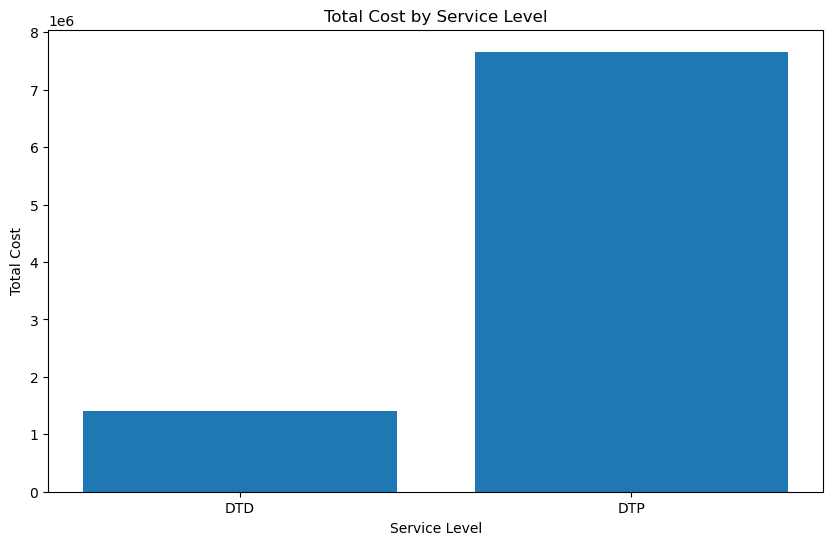

In [50]:
import matplotlib.pyplot as plt

grouped_data = compatible_carrier_orders.groupby('Service_Level')['total_cost'].sum()

plt.figure(figsize=(10, 6))
plt.bar(grouped_data.index, grouped_data.values)

plt.xlabel('Service Level') 
plt.ylabel('Total Cost')
plt.title('Total Cost by Service Level')  
plt.show()


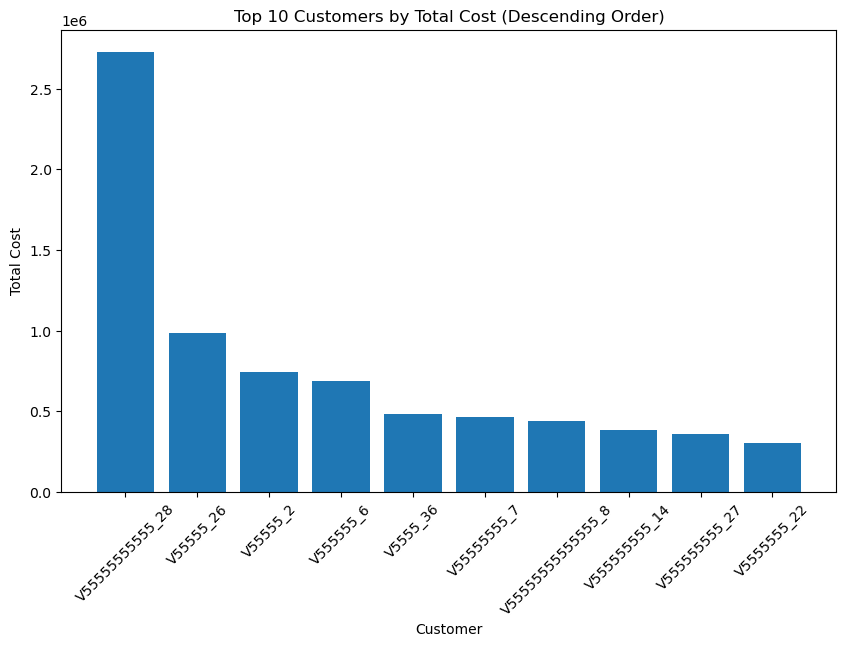

In [51]:
import matplotlib.pyplot as plt

grouped_data = compatible_carrier_orders.groupby('Customer')['total_cost'].sum()

top_customers = grouped_data.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))  
plt.bar(top_customers.index, top_customers.values)

plt.xlabel('Customer')
plt.ylabel('Total Cost')
plt.title('Top 10 Customers by Total Cost (Descending Order)')

plt.xticks(rotation=45)
plt.show()


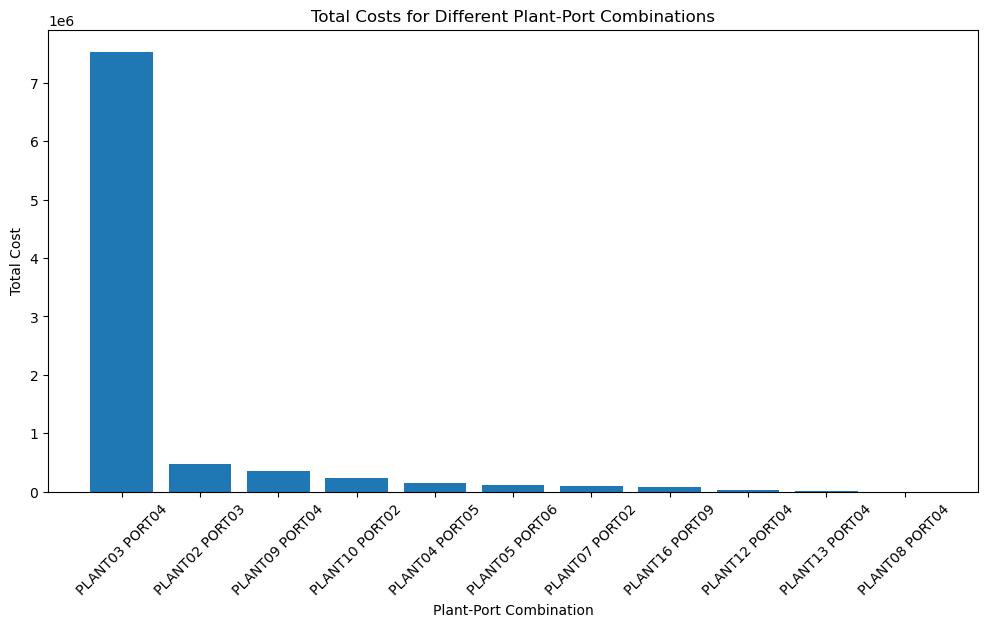

In [52]:
import matplotlib.pyplot as plt

plant_port_costs = compatible_carrier_orders.groupby(['avail_plant', 'avail_port'])['total_cost'].sum().reset_index()
plant_port_costs = plant_port_costs.sort_values('total_cost', ascending=False)

plt.figure(figsize=(12, 6))

plt.bar(plant_port_costs['avail_plant'] + ' ' + plant_port_costs['avail_port'], plant_port_costs['total_cost'])

plt.xlabel('Plant-Port Combination')

plt.ylabel('Total Cost')

plt.title('Total Costs for Different Plant-Port Combinations')

plt.xticks(rotation=45)
plt.show()


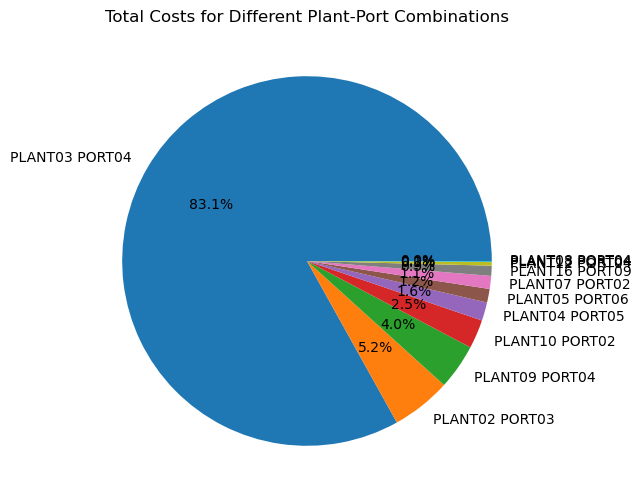

In [53]:
import matplotlib.pyplot as plt

plant_port_costs = compatible_carrier_orders.groupby(['avail_plant', 'avail_port'])['total_cost'].sum().reset_index()
plant_port_costs = plant_port_costs.sort_values('total_cost', ascending=False)

plt.figure(figsize=(10, 6))

plt.pie(plant_port_costs['total_cost'], labels=plant_port_costs['avail_plant'] + ' ' + plant_port_costs['avail_port'], autopct='%1.1f%%')

plt.title('Total Costs for Different Plant-Port Combinations')

plt.show()


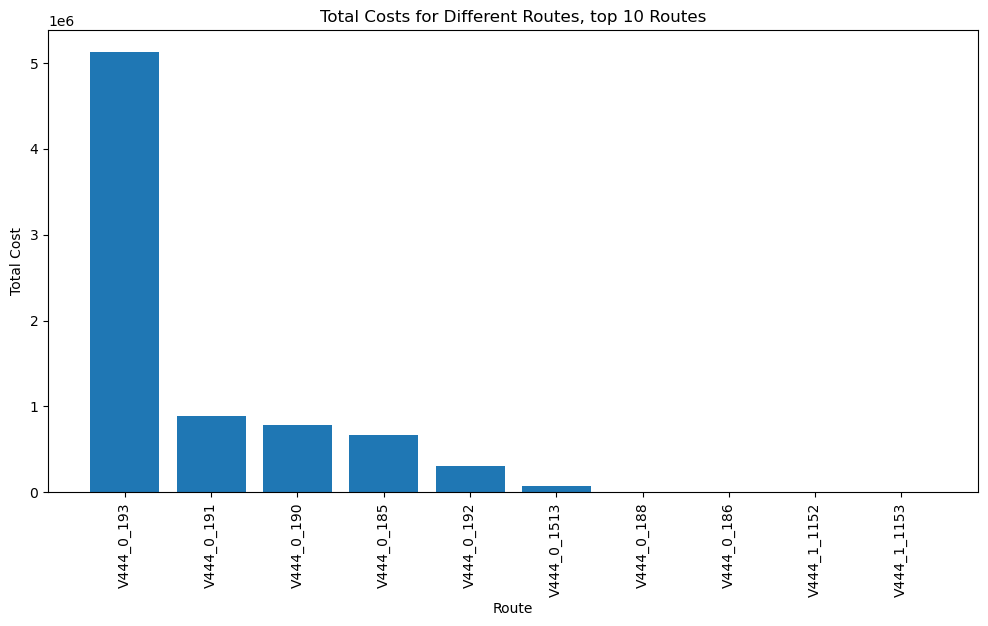

In [54]:
import matplotlib.pyplot as plt

route_costs = compatible_carrier_orders.groupby('route_key')['total_cost'].sum().reset_index().head(10)
route_costs = route_costs.sort_values('total_cost', ascending=False)

plt.figure(figsize=(12, 6))

plt.bar(route_costs['route_key'], route_costs['total_cost'])

plt.xlabel('Route')

plt.ylabel('Total Cost')

plt.title('Total Costs for Different Routes, top 10 Routes')

plt.xticks(rotation=90)

plt.show()


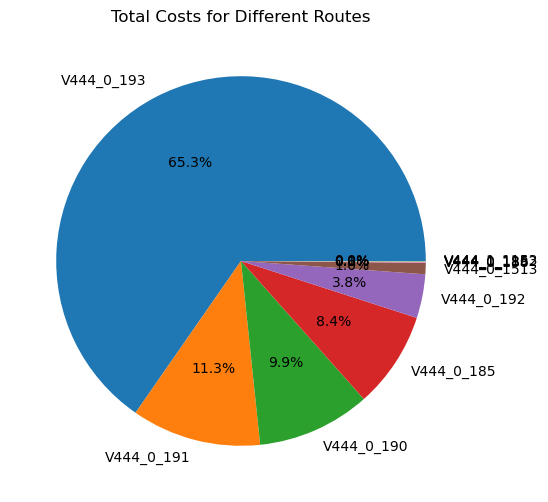

In [55]:
import matplotlib.pyplot as plt

route_costs = compatible_carrier_orders.groupby('route_key')['total_cost'].sum().reset_index().head(10)
route_costs = route_costs.sort_values('total_cost', ascending=False)

plt.figure(figsize=(10, 6))

plt.pie(route_costs['total_cost'], labels=route_costs['route_key'], autopct='%1.1f%%')

plt.title('Total Costs for Different Routes')

plt.show()

### All feasible Plant-Port combination

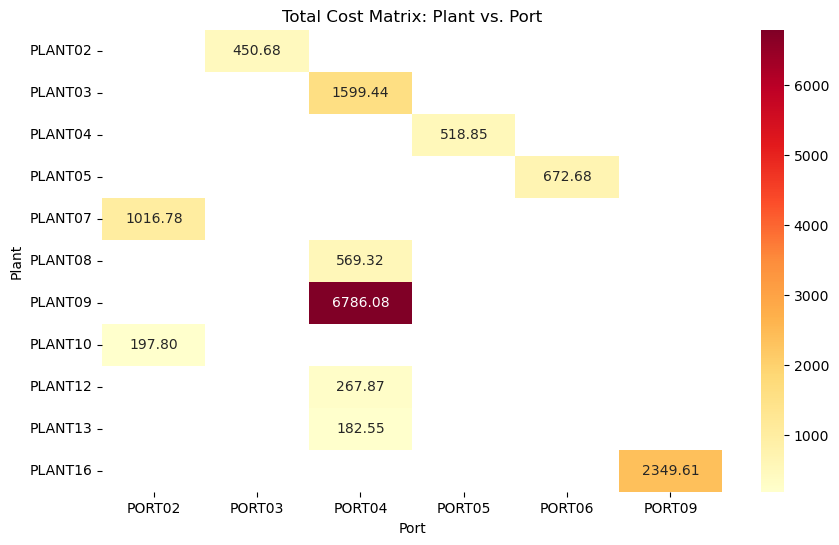

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot_table = compatible_carrier_orders.pivot_table(values='total_cost', index='avail_plant', columns='avail_port')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt=".2f")
plt.title('Total Cost Matrix: Plant vs. Port')
plt.xlabel('Port')
plt.ylabel('Plant')
plt.show()


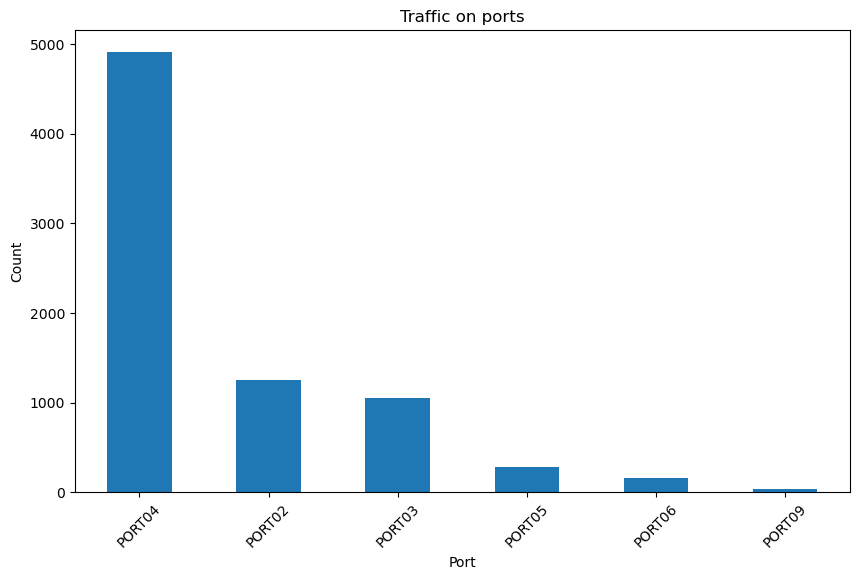

Busiest Port: PORT04


In [57]:
import matplotlib.pyplot as plt

port_counts = compatible_carrier_orders['avail_port'].value_counts()

port_counts.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Port')
plt.ylabel('Count')
plt.title('Traffic on ports')
plt.xticks(rotation=45)


plt.show()

Busiest_port = port_counts.idxmax()
print("Busiest Port:", Busiest_port)

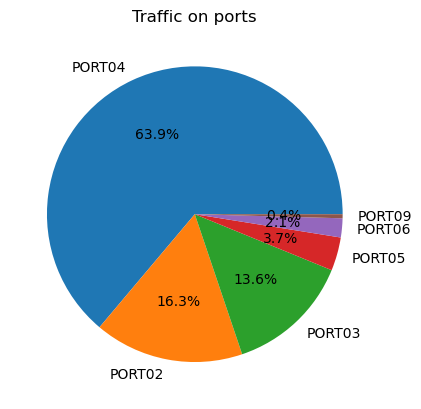

Busiest port: PORT04


In [58]:
import matplotlib.pyplot as plt

port_counts = compatible_carrier_orders['avail_port'].value_counts()

plt.pie(port_counts, labels=port_counts.index, autopct='%1.1f%%')

plt.title('Traffic on ports')

plt.show()

Busiest_port = port_counts.idxmax()
print("Busiest port:", Busiest_port)


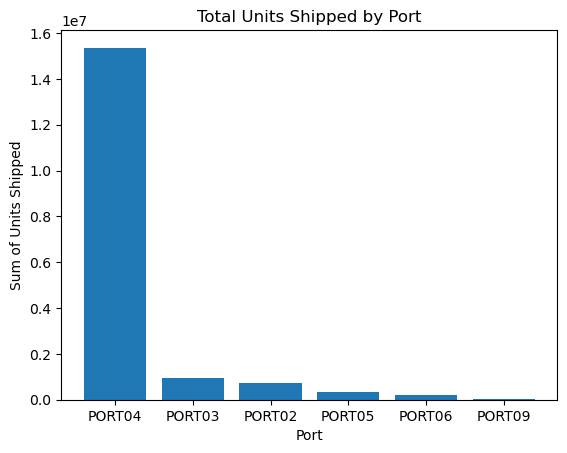

In [59]:
import matplotlib.pyplot as plt

port_units_sum = compatible_carrier_orders.groupby('avail_port')['Unit_quantity'].sum().sort_values(ascending=False)

plt.bar(port_units_sum.index, port_units_sum)

plt.xlabel('Port')
plt.ylabel('Sum of Units Shipped')
plt.title('Total Units Shipped by Port')

plt.show()

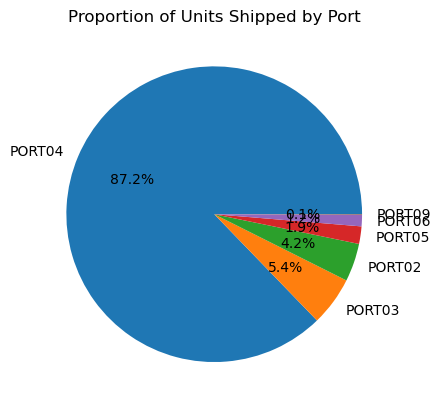

In [60]:
import matplotlib.pyplot as plt

port_units_sum = compatible_carrier_orders.groupby('avail_port')['Unit_quantity'].sum().sort_values(ascending=False)

plt.pie(port_units_sum, labels=port_units_sum.index, autopct='%1.1f%%')

plt.title('Proportion of Units Shipped by Port')

plt.show()


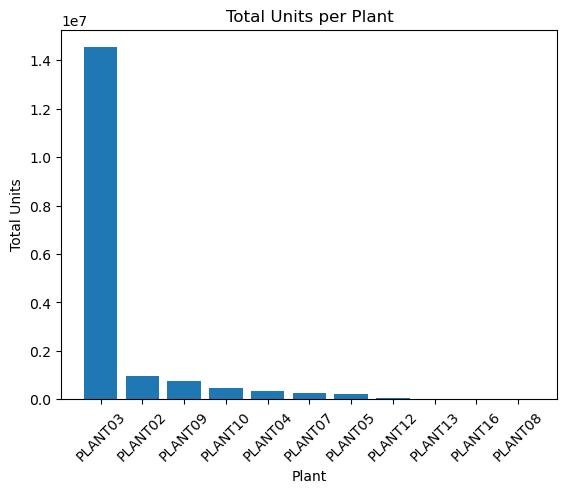

In [61]:
import matplotlib.pyplot as plt

plant_units = compatible_carrier_orders.groupby('avail_plant')['Unit_quantity'].sum()

sorted_data = plant_units.sort_values(ascending=False)

plt.bar(sorted_data.index, sorted_data.values)

plt.xlabel('Plant')
plt.ylabel('Total Units')
plt.title('Total Units per Plant')

plt.xticks(rotation=45)
plt.show()


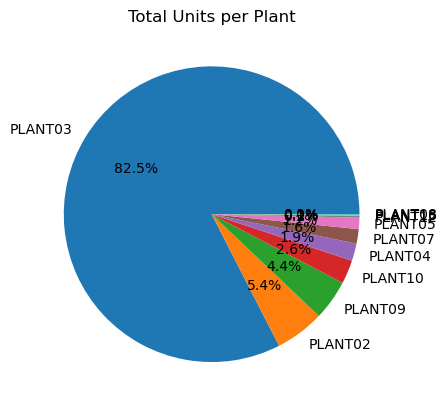

In [62]:
import matplotlib.pyplot as plt

plant_units = compatible_carrier_orders.groupby('avail_plant')['Unit_quantity'].sum()

sorted_data = plant_units.sort_values(ascending=False)

plt.pie(sorted_data.values, labels=sorted_data.index, autopct='%1.1f%%')

plt.title('Total Units per Plant')

plt.show()


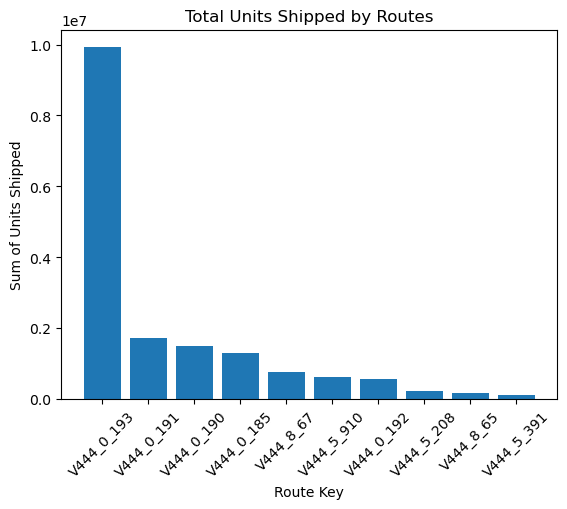

In [63]:
import matplotlib.pyplot as plt

route_units_sum = compatible_carrier_orders.groupby('route_key')['Unit_quantity'].sum().sort_values(ascending=False).head(10)

plt.bar(route_units_sum.index, route_units_sum)

plt.xlabel('Route Key')
plt.ylabel('Sum of Units Shipped')
plt.title('Total Units Shipped by Routes')

plt.xticks(rotation=45)
plt.show()


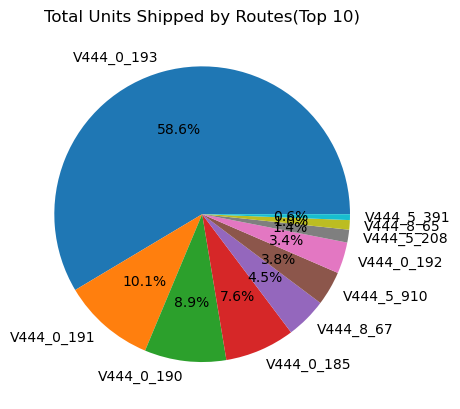

In [64]:
import matplotlib.pyplot as plt

route_units_sum = compatible_carrier_orders.groupby('route_key')['Unit_quantity'].sum().sort_values(ascending=False).head(10)

plt.pie(route_units_sum, labels=route_units_sum.index, autopct='%1.1f%%')

plt.title('Total Units Shipped by Routes(Top 10)')

plt.show()


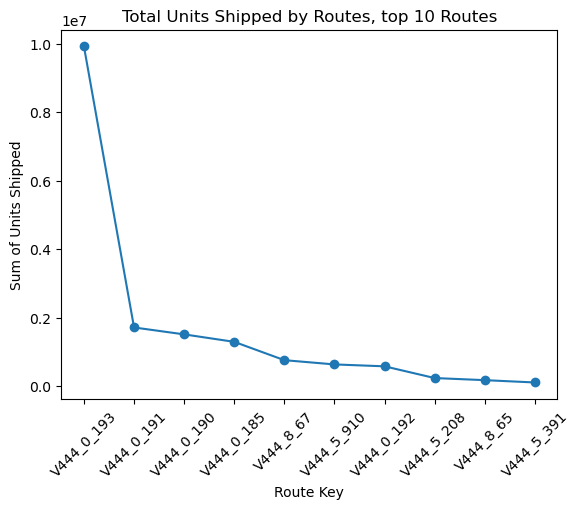

In [65]:
import matplotlib.pyplot as plt

route_units_sum = compatible_carrier_orders.groupby('route_key')['Unit_quantity'].sum().sort_values(ascending=False).head(10)

plt.plot(route_units_sum.index, route_units_sum, marker='o')

plt.xlabel('Route Key')
plt.ylabel('Sum of Units Shipped')
plt.title('Total Units Shipped by Routes, top 10 Routes')

plt.xticks(rotation=45)
plt.show()


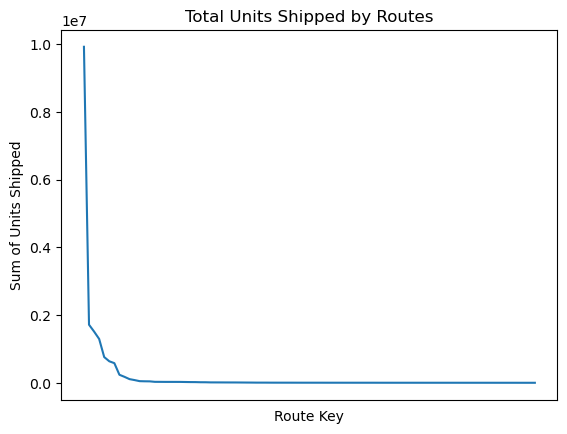

In [66]:
import matplotlib.pyplot as plt

route_units_sum = compatible_carrier_orders.groupby('route_key')['Unit_quantity'].sum().sort_values(ascending=False)

plt.plot(route_units_sum.index, route_units_sum)

plt.xlabel('Route Key')
plt.ylabel('Sum of Units Shipped')
plt.title('Total Units Shipped by Routes')

plt.xticks([])
plt.show()


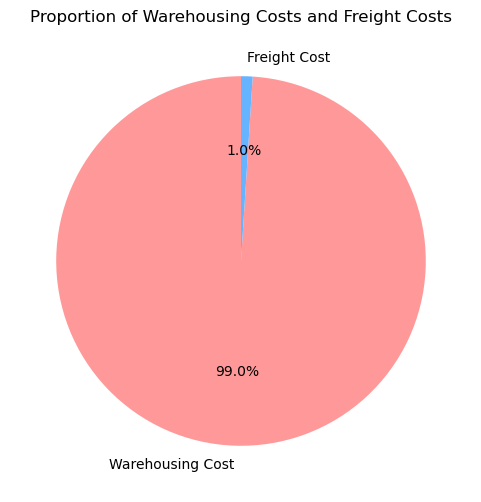

In [67]:
import matplotlib.pyplot as plt

total_warehousing_cost = compatible_carrier_orders['wh_cost'].sum()
total_freight_cost = compatible_carrier_orders['freight_cost'].sum()

labels = ['Warehousing Cost', 'Freight Cost']

values = [total_warehousing_cost, total_freight_cost]

colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

plt.title('Proportion of Warehousing Costs and Freight Costs')
plt.show()

In [ ]:
# Comparative analysis

In [75]:
percentage_decrement = ((total_cost_summed_original - total_cost_summed) / total_cost_summed_original) * 100

print(f"The cost has decreased by {percentage_decrement:.2f}%")

The cost has decreased by 32.40%
